In [1]:
import numpy as np
import matplotlib.pyplot as plt
import caiman as cm
import sys
import os
import re
from glob import glob
sys.path.insert(0,os.path.expanduser("/data2/Code/zebrafish_passivity"))
sys.path.insert(0,os.path.expanduser("/data2/Code/zebrafish_passivity/deepfish"))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Deep skip

In [2]:
from __future__ import print_function, division
import os
import sys
import datetime

# sys.path.insert(0,os.path.expanduser("deepfish"))
from deepfish.deep_skip import DeepSkip, train
Model = DeepSkip

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
# import apex # https://github.com/NVIDIA/apex.git
# from apex.amp import amp


import os, sys, datetime
import itertools
# LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
# FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
# FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
# sys.path.insert(0,LF_CODE_PATH)
# sys.path.insert(0,FT_CODE_PATH)
# sys.path.insert(0,FD_CODE_PATH)

# import passivity_2p_imaging_utils as p2putils
# reload(p2putils)
tmp_dir = '/tmp/'
# all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

# sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half

T.backends.cudnn.benchmark = True

# PARAMETERS
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
kl_lambda = 5e-4
sparse_lambda=1e-3
lr=1e-3
nepochs = 11
nEmbedding = 20
# batch_size = 6
batch_size = 32

In [3]:
class ZebraFishDataRNA(Dataset):
    "B x nFrames x Z x H x W"
    def __init__(self, imaging, structural, shocks, tail_movements,
                 index_map=None, prev_frames=2, next_frames=1):
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.shocks = shocks
        self.tail_movements = tail_movements
        self.index_map = index_map
        self.structural = structural

    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        "X[0]==X_i, X[1]==X_i-1, Y[0]==Y_i+1, Y[1]==Y_i+2"
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        X = {"brain": [], "shock": [], "tail_movement": []}
        Y = {"brain": [], "shock": [], "tail_movement": []}
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            X["brain"].append(self.data[ix])
            X["shock"].append(self.shocks[ix])
            X["tail_movement"].append(self.tail_movements[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            Y["brain"].append(self.data[ix])
            Y["shock"].append(self.shocks[ix])
            Y["tail_movement"].append(self.tail_movements[ix])
        for s in structural:
            X["brain"].append(s)
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y


In [4]:
from tifffile import imread
from glob import glob
import re

In [5]:
directory = "/data2/Data/f10542/"

In [94]:
get_num = re.compile(".*_zplane=(\d*).npy")
get_z = lambda x: int(get_num.search(x).group(1))
# planes = glob(directory+"functional*.npy")
structural = glob(directory+"cnmf/*.npy")
structural = list(filter(lambda x: get_num.match(x) is None, structural))
# planes = sorted(planes, key=lambda a: get_z(a))
# nZ = len(planes)
# print(f"Number of planes: {nZ}")
structural

['/data2/Data/f10542/cnmf/functional.npy',
 '/data2/Data/f10542/cnmf/isosbestic_gcamp.npy',
 '/data2/Data/f10542/cnmf/corners.npy',
 '/data2/Data/f10542/cnmf/postfix_gcamp.npy',
 '/data2/Data/f10542/cnmf/postfix_gad.npy',
 '/data2/Data/f10542/cnmf/postfix_vglut.npy']

In [255]:
imaging = np.load(directory+"cnmf/functional.npy")

In [97]:
isosbestic_gcamp = np.load(structural[1])
postfix_gcamp = np.load(structural[3])
postfix_gad = np.load(structural[4])
postfix_vglut = np.load(structural[5])

structural = T.from_numpy(np.stack([isosbestic_gcamp, postfix_gcamp, postfix_gad, postfix_vglut]))
structural.shape

torch.Size([4, 29, 256, 256])

In [99]:
mean_frame = imaging.mean(0)

nT, nZ, H, W = imaging.shape
nT, nZ, H, W

(5437, 29, 256, 256)

In [100]:
shocks = T.from_numpy(np.zeros(nT).astype(np.float32))
tail_movements = T.from_numpy(np.zeros(nT).astype(np.float32))

In [256]:
del imaging

['train: 4868 (96.05%)', 'validation: 0 (0.00%)', 'test: 200 (3.95%)']


In [257]:
del imaging

In [258]:
gc.collect()

1633

In [13]:
from __future__ import print_function, division
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from volume import Vol2D
from resnet import ResNet, BasicBlock
from super_res import SuperResSkip
from torch.utils.data import DataLoader, Dataset
from misc import sigmoid_schedule
from tqdm import tqdm



class DeepSkip(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(DeepSkip, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 16
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 64
        self.nEmbedding = nEmbedding
        assert nEmbedding % 2 == 0

        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.nhalf_embed = int(self.nEmbedding/2)
        # Prediction
        self.pred1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Prediction
        self.predz1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.predz2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(self.nhalf_embed,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResSkip(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResSkip(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResSkip(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResSkip(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResSkip(2,tensor)
        # 11 x 256 x 512

        self.tail_decoding = nn.Linear(1,1)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)

    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        x = x.transpose(1,2)
        # X :: b x z x t x h x w
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
#                 print("layer_out "+k+" shape: "+ str(layer_out[k].shape))
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs

    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x

    def predictZero(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.predz1(x))
        x = self.predz2(x)
        return x

    def decode(self, x, layer_output):
        tail = T.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
#         tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail

    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_prev = self.predictZero(encoded[:,self.nhalf_embed:], shock)
        encoded_pred = self.predict(encoded[:,:self.nhalf_embed], shock)
        prev = self.decode(encoded_prev, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?

def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)

    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        i = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)

        avg_Y_loss = cum_Y_loss/len(train_data)
        avg_X_loss = cum_X_loss/len(train_data)
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), avg_X_loss, avg_Y_loss, cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))
#         cum_loss = 0
#         cum_X_loss = 0
#         cum_Y_loss = 0
#         cum_kld_loss = 0
#         cum_tail_loss = 0
#         model.eval()
#         gc.collect()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
#             if half:
#                 X_pred = X_pred.float()
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             kld = unit_norm_KL_divergence(mean, logvar)
#             mse_X = F.mse_loss(X_pred, Y[:,0])
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
#             loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
#             cum_loss += float(loss)
#             cum_X_loss += float(mse_X)
#             cum_Y_loss += float(mse_Y)
#             cum_kld_loss += float(kld)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_loss, avg_Y_loss, avg_Y_valid_loss


def validation_loss(model,valid_data, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    cum_loss = 0
    cum_X_loss = 0
    cum_Y_loss = 0
    cum_kld_loss = 0
    cum_tail_loss = 0
    with T.no_grad():
        model.eval()
        for batch_data in tqdm(valid_dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda * kld + kl_tail*mse_tail
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)
    model.train()
    avg_Y_valid_loss = cum_Y_loss/len(valid_data)
    avg_X_valid_loss = cum_X_loss/len(valid_data)
    print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
    cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_valid_loss, avg_Y_valid_loss


In [14]:
batch_size = 8
multi_gpu = True

tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

# conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames + len(structural),next_frames, tensor=tensor)
conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames,next_frames, tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 1420430


In [15]:
conv_model.load_state_dict(T.load("/data2/trained_models/"+
#                                   "190113_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}.pt"))
#     "190112_f15042_notail_nostructure_epoch=12_xloss=1.11E+2_yloss=1.29E+2.pt"))
    "190114_f15042_notail_nostructure_cnmf_folder_epoch=6_xloss=1.250E+02_yloss=1.447E+02.pt"))

# Caiman

In [16]:
# load cnmf results
get_num = re.compile(".*_zplane=(\d*).*")
get_z = lambda x: int(get_num.search(x).group(1))
planes = glob(directory + "cnmf/*cnmf.npz")
planes = sorted(planes, key=lambda a: get_z(a))

cnmf_results = []
for file in planes:
    cnmf_results.append(np.load(file))
    

In [17]:
# load cnmf results
get_num = re.compile(".*_zplane=(\d*).*")
get_z = lambda x: int(get_num.search(x).group(1))
vid_planes = glob(directory + "cnmf/*.mmap")
vid_planes = sorted(vid_planes, key=lambda a: get_z(a))

In [18]:
# construct neuron x T matrix
neurons = []

for res in cnmf_results:
    neurons.append(res['C'])

def slice_neurons(neurons):
    indices = []
    start = 0
    for n in neurons:
        N = n.shape[0]
        indices.append(slice(start, start+N))
        start += N
    return indices

neuron_plane = slice_neurons(neurons)
neurons = np.vstack(neurons)

    

# construct pixels x neuron matrix
spatial = []

# startNeuron = 0
for res in cnmf_results:
#     n_pixels, n_comps = res['A'].shape
#     plane_spatial = np.zeros([n_pixels, nNeurons])
#     plane_spatial[:,startNeuron:startNeuron+n_comps] = res['A']
#     spatial.append(plane_spatial.copy())
    spatial.append(res['A'])

In [19]:
nNeurons, nT  = neurons.shape
nNeurons, nT

(7807, 5437)

In [20]:
spatial[0].shape

(180224, 150)

In [21]:
n_frames_ahead = 5
X = []
Y = []
for idx in tvt_split['train']:
    X.append(neurons[:,[idx]])
    Y.append(neurons[:,[idx+n_frames_ahead]])
X = np.hstack(X)
Y = np.hstack(Y)

X_valid = []
Y_valid = []
for idx in tvt_split['test']:
    X_valid.append(neurons[:,[idx]])
    Y_valid.append(neurons[:,[idx+n_frames_ahead]])
X_valid = np.hstack(X_valid)
Y_valid = np.hstack(Y_valid)

In [22]:
A_lstsq = np.linalg.lstsq(np.transpose(X),np.transpose(Y))
A = np.transpose(A_lstsq[0])

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [23]:
y_pred = A @ X
yloss = np.sum((Y - y_pred)**2)
yloss

1.0072362939219696e-13

In [24]:
y_valid_pred = A @ X_valid
y_valid_loss = np.sqrt(np.sum((Y_valid - y_valid_pred)**2))
y_valid_loss

627901.1682454486

In [25]:
# A is spatial
# C are components
# f @ b is background
list(cnmf_results[0].keys())

['Cn',
 'A',
 'C',
 'b',
 'f',
 'YrA',
 'd1',
 'd2',
 'idx_components',
 'idx_components_bad',
 'sn',
 'contours']

In [160]:
plane = np.array(cm.load(directory + "cnmf/f10542_zplane=10_els__d1_352_d2_512_d3_1_order_F_frames_5437_.mmap"))

H, W = plane[0].shape
plane_spatial = res["A"][:,]
plane_spatial = np.transpose(spatial.reshape(W,H,-1))
plane_spatial.shape
all_spatial = plane_spatial.sum(0)
plt.matshow(all_spatial)

In [260]:
nT, H, W = plane.shape

In [28]:
# corners = np.load(directory+"corners.npy")
corners_cnmf = np.load(directory+"cnmf/corners.npy")

In [244]:
def caiman_vec_to_2D(x):
    return np.transpose(x.reshape(W,H))

def caiman_loss(pred, spatial, frame, bg, mask):
    """ Calculate loss for apples-to-apples comparison with deep-skip
    pred: vector of ncomponents
    spatial: npixels x ncomponents ['A']
    frame: (T x) H x W
    """
    pred_frame = spatial @ pred + bg
    pred_frame = caiman_vec_to_2D(pred_frame)
    # make same dimensions as deep-skip training
    mask_dl_px = caiman_px_to_dl_px(mask, corners_cnmf)
    frame_dl_px = caiman_px_to_dl_px(frame, corners_cnmf)
    pred_frame_dl_px = caiman_px_to_dl_px(pred_frame, corners_cnmf)
    return np.sqrt(np.sum((frame_dl_px*mask_dl_px-pred_frame_dl_px*mask_dl_px)**2))

def deep_skip_predict(model, batch, mask, plane):
    with T.no_grad():
        model.eval()
        X, Y = batch
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        X = X[None]
        X_shock = X_shock[None]
        X_tail = X_tail[None]
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        Y = Y[None]
        Y_shock = Y_shock[None]
        Y_tail = Y_tail[None]
        if cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_shock = X_shock.cuda()
            Y_shock = Y_shock.cuda()
            X_tail = X_tail.cuda()
            Y_tail = Y_tail.cuda()
        (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
        if half:
            X_pred = X_pred.float()
            Y_pred = Y_pred.float()
            mean = mean.float()
            logvar = logvar.float()
        tmask = T.from_numpy(mask).cuda()
#         mse_Y = F.mse_loss(Y_pred[0,p]*tmask, Y[0,-1,p]*tmask, size_average=False)
        mse_Y = T.sqrt(T.sum((Y_pred[0,plane]*tmask - Y[0,-1,plane]*tmask)**2))
        model.train()
        return mse_Y, Y_pred

In [57]:
def pad_image(image, H, W):
    try:
        assert image.shape[0] <= H and image.shape[1] <= W
    except Exception as e:
        print("H ({}) and W ({}) must be less than {} and {}".format(H, W, image.shape[0], image.shape[1]))
        raise e
    new_image = np.zeros([H,W])
    if image.shape[0]==H:
        pad_top = False
    else:
        pad_top = int(np.floor((H-image.shape[0])/2))
        pad_bottom = int(np.ceil((H-image.shape[0])/2))
    if image.shape[0]==W:
        pad_left = False
    else:
        pad_left = int(np.floor((W-image.shape[1])/2))
        pad_right = int(np.ceil((W-image.shape[1])/2))
    if not pad_left and not pad_top:
        return image
    elif pad_right and not pad_bottom:
        new_image[:,pad_left:(-pad_right)] = image
    elif pad_bottom and not pad_right:
        new_image[pad_top:(-pad_bottom),:] = image
    else:
        new_image[pad_top:(-pad_bottom),pad_left:(-pad_right)] = image
    return new_image.astype(np.float32)

In [55]:
def caiman_px_to_dl_px(image, corners):
    """Convert from Caiman image space, to DL image space
    ie 0.5 downsample, crop, pad to 256 x 256 
    """
    cropped = image[corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]]
    resized = cv2.resize(cropped, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    padded = pad_image(resized, 256, 256)
    return padded

def load_vol(t):
    vol = None
    for z,p in enumerate(vid_planes):
        plane = np.array(cm.load(p)[t])
        if vol is None:
            vol = np.zeros([len(planes), *plane.shape])
        vol[z] = plane
    return vol

def proj_components(spatial, vol):
    proj = []
    for p,sp in enumerate(spatial):
        plane_proj = np.linalg.lstsq(sp,vol[p].reshape(-1))[0]
        proj.append(plane_proj)
    return np.hstack(proj)

In [162]:
plane0_bg = caiman_vec_to_2D(
    (cnmf_results[10]["b"] @ cnmf_results[10]["f"][:, tvt_split['train']]).mean(1))

## train

In [272]:
p = 10
t = 0
plane_t = tvt_split['train'][t]

In [274]:
vol = load_vol(plane_t)

In [275]:
proj = proj_components(spatial, vol)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [318]:
mask = caiman_vec_to_2D(spatial[p].sum(1))
batch = train_data[t]
mse_Y, conv_Y_pred_train = deep_skip_predict(conv_model, batch, caiman_px_to_dl_px(mask, corners_cnmf), p)
mse_Y

tensor(1108.9434, device='cuda:0')

In [319]:
est = A @ X[:,t]
caiman_loss(est[neuron_plane[p]],spatial[p],plane[plane_t+5], plane0_bg.reshape(-1), mask)

1893.1271

est = A @ proj
caiman_loss(est[neuron_plane[p]],spatial[p],plane[plane_t+5], plane0_bg.reshape(-1), mask)

Text(0.5,1.05,'Deep Learning')

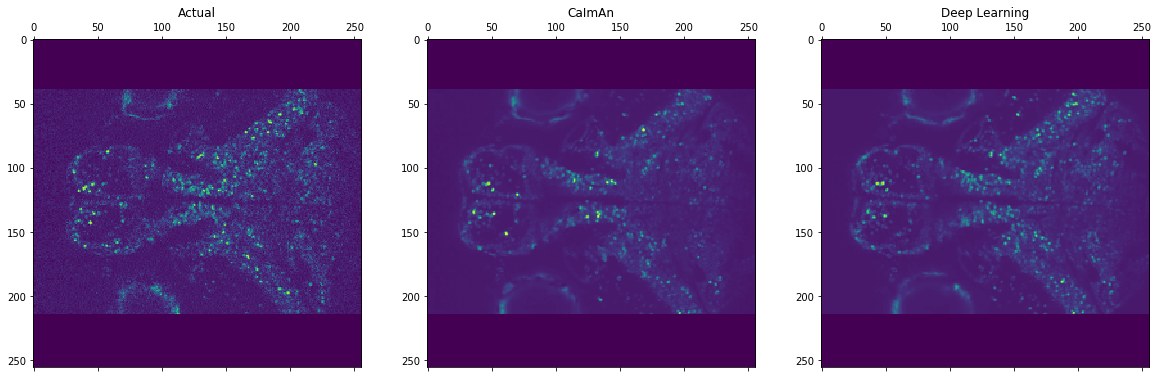

In [320]:
fig, ax = plt.subplots(1,3, figsize=(20,20))
actual = caiman_px_to_dl_px(plane[plane_t], corners_cnmf)
ax1 = ax[0].matshow(actual)
clim=ax1.properties()['clim']
ax[0].set_title("Actual")
CaImAn = caiman_px_to_dl_px(caiman_vec_to_2D(spatial[p] @ est[neuron_plane[p]])+ plane0_bg, corners_cnmf)
ax[1].matshow(CaImAn, clim=clim)
ax[1].set_title("CaImAn")
dl = (conv_Y_pred[0,p].cpu().numpy()+mean_frame[p])#*caiman_px_to_dl_px(mask)
ax[2].matshow(dl, clim=clim)
ax[2].set_title("Deep Learning")

In [321]:
np.sqrt(np.sum((actual-CaImAn)**2))

19989.006

In [322]:
np.sqrt(np.sum((actual-dl)**2))

19505.895

## test

In [303]:
p = 10
t = 0
plane_t = tvt_split['test'][t]
batch = test_data[t]
mask = caiman_vec_to_2D(spatial[p].sum(1))
mse_Y, conv_Y_pred_test = deep_skip_predict(conv_model, batch, caiman_px_to_dl_px(mask, corners_cnmf), p)
mse_Y

tensor(997.0349, device='cuda:0')

In [304]:
vol = load_vol(plane_t)

In [305]:
proj = proj_components(spatial, vol)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [313]:
est = A @ X_valid[:,t]
caiman_loss(est[neuron_plane[p]],spatial[p],plane[plane_t+5], plane0_bg.reshape(-1), mask)

2068.8179

In [307]:
est = A @ proj
caiman_loss(est[neuron_plane[p]],spatial[p],plane[plane_t+5], plane0_bg.reshape(-1), mask)
# 832

5043.165

Text(0.5,1.05,'Deep Learning')

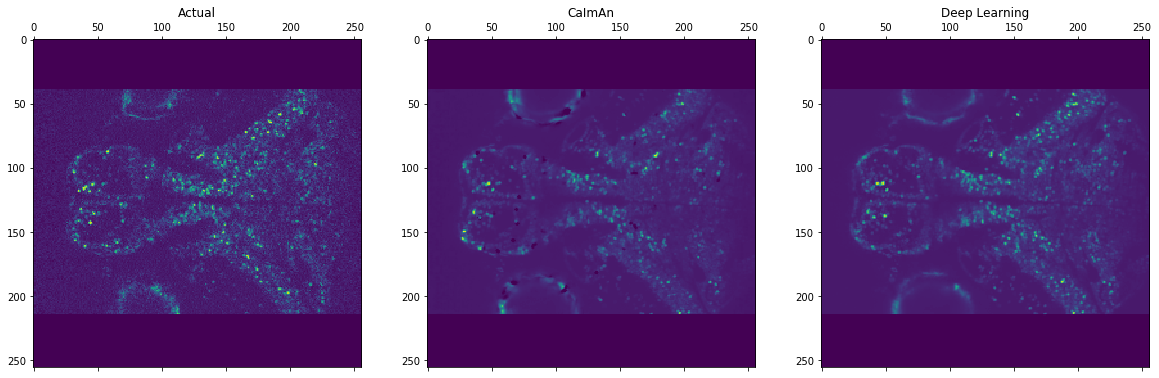

In [314]:
fig, ax = plt.subplots(1,3, figsize=(20,20))
actual = caiman_px_to_dl_px(plane[plane_t], corners_cnmf)
ax1 = ax[0].matshow(actual)
clim=ax1.properties()['clim']
ax[0].set_title("Actual")
CaImAn = caiman_px_to_dl_px(caiman_vec_to_2D(spatial[p] @ est[neuron_plane[p]])+ plane0_bg, corners_cnmf)
ax[1].matshow(CaImAn, clim=clim)
ax[1].set_title("CaImAn")
dl = (conv_Y_pred[0,p].cpu().numpy()+mean_frame[p])#*caiman_px_to_dl_px(mask)
ax[2].matshow(dl, clim=clim)
ax[2].set_title("Deep Learning")

In [315]:
np.sqrt(np.sum((actual-CaImAn)**2))

20002.916

In [316]:
np.sqrt(np.sum((actual-dl)**2))

19505.895

In [297]:
mask_dl_px = caiman_px_to_dl_px(mask, corners_cnmf)

Text(0.5,1.05,'Deep Learning')

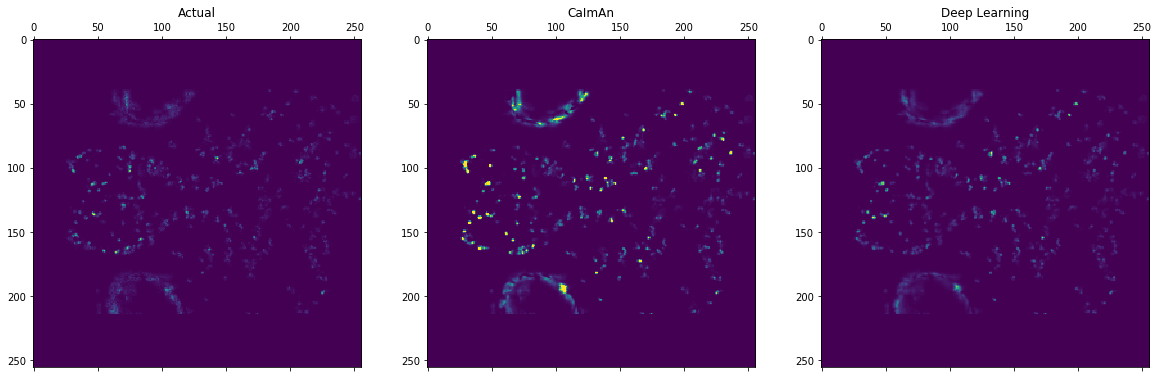

In [300]:
fig, ax = plt.subplots(1,3, figsize=(20,20))
actual = caiman_px_to_dl_px(plane[t], corners_cnmf)*mask_dl_px
ax1 = ax[0].matshow(actual)
clim=ax1.properties()['clim']
ax[0].set_title("Actual")
CaImAn = caiman_px_to_dl_px((caiman_vec_to_2D(spatial[p] @ est[neuron_plane[p]])+ plane0_bg), corners_cnmf)*mask_dl_px
ax[1].matshow(CaImAn, clim=clim)
ax[1].set_title("CaImAn")
dl = (conv_Y_pred[0,p].cpu().numpy()+mean_frame[p])*mask_dl_px
ax[2].matshow(dl, clim=clim)
ax[2].set_title("Deep Learning")

In [205]:
np.sqrt(np.sum((actual-CaImAn)**2))

702.43524

In [206]:
np.sqrt(np.sum((actual-dl)**2))

559.6084

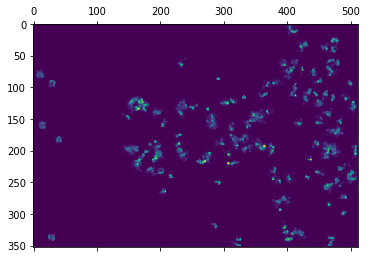

In [148]:
plt.matshow(mask)

In [ ]:
def caiman_loss_volume(pred, spatial, frame, bg, mask):
    """ Calculate loss for apples-to-apples comparison with deep-skip
    pred: vector of ncomponents
    spatial: npixels x ncomponents ['A']
    frame: (T x) H x W
    """
    pred_frame = spatial @ pred + bg
    pred_frame = caiman_vec_to_2D(pred_frame)
    # make same dimensions as deep-skip training
    mask_dl_px = caiman_px_to_dl_px(mask, corners_cnmf)
    frame_dl_px = caiman_px_to_dl_px(frame, corners_cnmf)
    pred_frame_dl_px = caiman_px_to_dl_px(pred_frame, corners_cnmf)
    return np.sqrt(np.sum((frame_dl_px*mask_dl_px-pred_frame_dl_px*mask_dl_px)**2))

def deep_skip_predict_volume(model, t, mask, plane):
    with T.no_grad():
        model.eval()
        X, Y = test_data[t]
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        X = X[None]
        X_shock = X_shock[None]
        X_tail = X_tail[None]
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        Y = Y[None]
        Y_shock = Y_shock[None]
        Y_tail = Y_tail[None]
        if cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_shock = X_shock.cuda()
            Y_shock = Y_shock.cuda()
            X_tail = X_tail.cuda()
            Y_tail = Y_tail.cuda()
        (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
        if half:
            X_pred = X_pred.float()
            Y_pred = Y_pred.float()
            mean = mean.float()
            logvar = logvar.float()
        tmask = T.from_numpy(mask).cuda()
#         mse_Y = F.mse_loss(Y_pred[0,p]*tmask, Y[0,-1,p]*tmask, size_average=False)
        mse_Y = T.sqrt(T.sum((Y_pred[0,p]*tmask - Y[0,-1,p]*tmask)**2))
        model.train()
        return mse_Y, Y_pred

In [65]:
model = conv_model
t = 0
with T.no_grad():
    model.eval()
    X, Y = test_data[t]
    X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
    X = X[None]
    X_shock = X_shock[None]
    X_tail = X_tail[None]
    Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
    Y = Y[None]
    Y_shock = Y_shock[None]
    Y_tail = Y_tail[None]
    if cuda:
        X = X.cuda()
        Y = Y.cuda()
        X_shock = X_shock.cuda()
        Y_shock = Y_shock.cuda()
        X_tail = X_tail.cuda()
        Y_tail = Y_tail.cuda()
    (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
    if half:
        X_pred = X_pred.float()
        Y_pred = Y_pred.float()
        mean = mean.float()
        logvar = logvar.float()
    mse_Y = F.mse_loss(Y_pred, Y[:,-1],size_average=False)

In [73]:
Y.max()

tensor(883.0811, device='cuda:0')

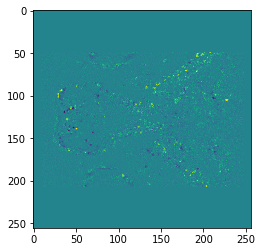

In [71]:
plt.imshow(Y[0,4,10])

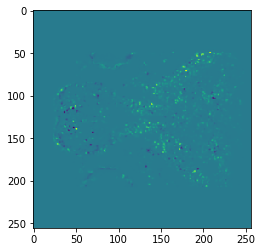

In [69]:
plt.imshow(Y_pred[0,10])

In [100]:
bg

array([76.67194704, 74.26374806, 77.26778486, ..., 77.24337793,
       76.05803522, 77.14519119])

In [158]:
res['A'].shape

(180224, 222)

In [328]:
neuron_plane[p]

slice(2122, 2497, None)

In [ ]:
frame_num = 3000
p = 10
signal = cnmf_results[p]['A'] @ cnmf_results[p]['C'][:,frame_num]
bg =  cnmf_results[p]['b'] @ cnmf_results[p]['f'][:,frame_num]
denoised = signal + bg

fig, ax = plt.subplots(1,4, figsize=(30,10))
ax[0].matshow(plane[frame_num])
ax[0].set_title("Actual plane")
ax[2].matshow(caiman_vec_to_2D(signal))
ax[2].set_title("Signal (AC)")
ax[3].matshow(caiman_vec_to_2D(bg))
ax[3].set_title("Background (bf)")
ax[1].matshow(caiman_vec_to_2D(denoised))
ax[1].set_title("Denoised (AC+bf)")

Text(0.5,1.05,'Denoised (AC+bf)')

# Comparison